# Apply PCM to 3D gridded products

Apply PCM method to __3D gridded products__ defined as inputs in BlueCloud project:
- GLOBAL-ANALYSIS-FORECAST-PHY-001-024
- GLOBAL_REANALYSIS_PHY_001_030
- GLOBAL_REANALYSIS_PHY_001_025 (No)
- GLOBAL_REANALYSIS_BIO_001_029

Only data in Mediterranean sea is used. NetCDF files have been downloaded from CMEMS catalogue.
Notebook developped in __local__

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

## User input
***

__Choose dataset__

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'
# GLOBAL_REANALYSIS_PHY_001_030
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1598523953615.nc'
# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'

# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
let_dim = 'latitude'
z_dim = 'depth'
temp_var = 'thetao'

#temp_var = 'o2'

__Model options__

In [3]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(0.,-2000,-10.)
#pcm_features = {'temperature': z}
pcm_features = {'temperature': z}

#classes
K=6

#fit
features_in_ds = {'temperature': temp_var}

__Plot options__

## Get data
***

Open data files

In [ ]:
#open data file
ds = xr.open_dataset(file_path)
ds

In [5]:
#at = ds['depth'].attrs
#ds.assign_coords(depth=-np.abs(ds['depth'].values))
ds['depth'] = -np.abs(ds['depth'].values)
#ds['depth'].attrs.update(at) # not working

In [ ]:
ds.attrs

In [7]:
coords_list = list(ds.coords.keys())
coords_list
#ds['depth'].attrs

['depth', 'latitude', 'time', 'longitude']

In [8]:
# make sqeeze before?
coords_list = list(ds.coords.keys())

coords_dict = {}
for c in coords_list:
    axis_at = ds[c].attrs.get('axis')
    if axis_at == 'Y':
        #creates dictionary latitude: c
        coords_dict.update({'latitude': c})
    if axis_at == 'X':
        #creates dictionary longitude: c
        coords_dict.update({'longitude': c})
    if axis_at == 'T':
        #creates dictionay time: c
        coords_dict.update({'time': c})
    if axis_at == 'Z':
        #creates dictionay time: c
        coords_dict.update({'depth': c})

#check number of variables in dict to assign data_type
#if 'latitude' in coords_dict and 'longitude' in coords_dict:
#    data_type = 'gridded'
#else:
#    data_type = 'profiles'
    
coords_dict


{'latitude': 'latitude', 'time': 'time', 'longitude': 'longitude'}

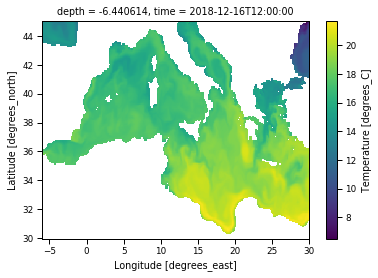

In [9]:
#ds['thetao'].isel(depth=5).plot();
ds['thetao'].isel(time=11, depth=5).plot();
#ds['o2'].isel(time=11, depth=5).plot();
#ds['fe'].isel(time=11, depth=5).plot();

<font color=red>__TODO__</font> : Use more tha TEMP variable

## Applying PCM
***

### Create PCM

In [10]:
#z choise
z = ds['depth'][1:20]
pcm_features = {'temperature': z}
#pcm_features = {'oxygen': z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [11]:
features_in_ds = {'temperature': temp_var}
#features_in_ds = {'oxygen': temp_var}
features_zdim=z_dim
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 43.245623

<font color=red>__TODO__</font> : save all trained PCM in a folder

### Classify data

In [ ]:
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
ds

In [13]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [14]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=temp_var, outname=temp_var + '_Q', keep_attrs=True, inplace=True)
#ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Visualisation
***

In [15]:
P = Plotter(ds.squeeze(), m, data_type = 'gridded')

#### 1. Vertical structure of classes

Figure saved in figures/vertical_struc_EX.png


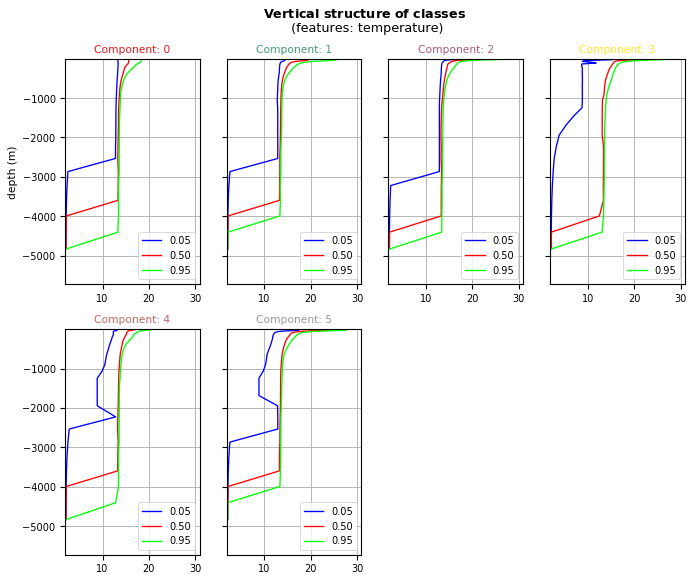

In [16]:
P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 8), sharey=True)
#P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 8), sharey=True, ylim=np.array([-2000,0]))
P.save_BlueCloud('figures/vertical_struc_EX.png')

#### 2. Spatial distribution of classes

In [17]:
ds.isel(time=8)
ds['time'][8]

<xarray.DataArray 'time' ()>
array('2018-09-16T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-09-16

In [18]:
# Create a new plotter object and chose time step (is it the best idea?)
Ps = Plotter(ds.isel(time=8), m, data_type = 'gridded')
#Ps = Plotter(ds.squeeze(), m, data_type = 'gridded')

Figure saved in figures/spatial_distr_EX.png


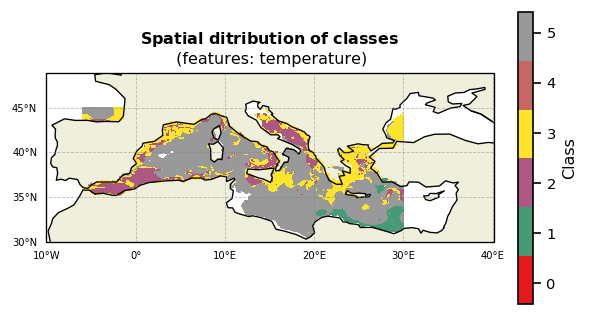

In [19]:
# Input should have only one time step
Ps.spatial_distribution(proj=ccrs.PlateCarree(), 
                        extent=np.array([-10,40,30,46]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                        co = {'latitude':'latitude', 'longitude':'longitude'})

Ps.save_BlueCloud('figures/spatial_distr_EX.png')

#### 3. Posteriors

Figure saved in figures/posteriors_EX.png


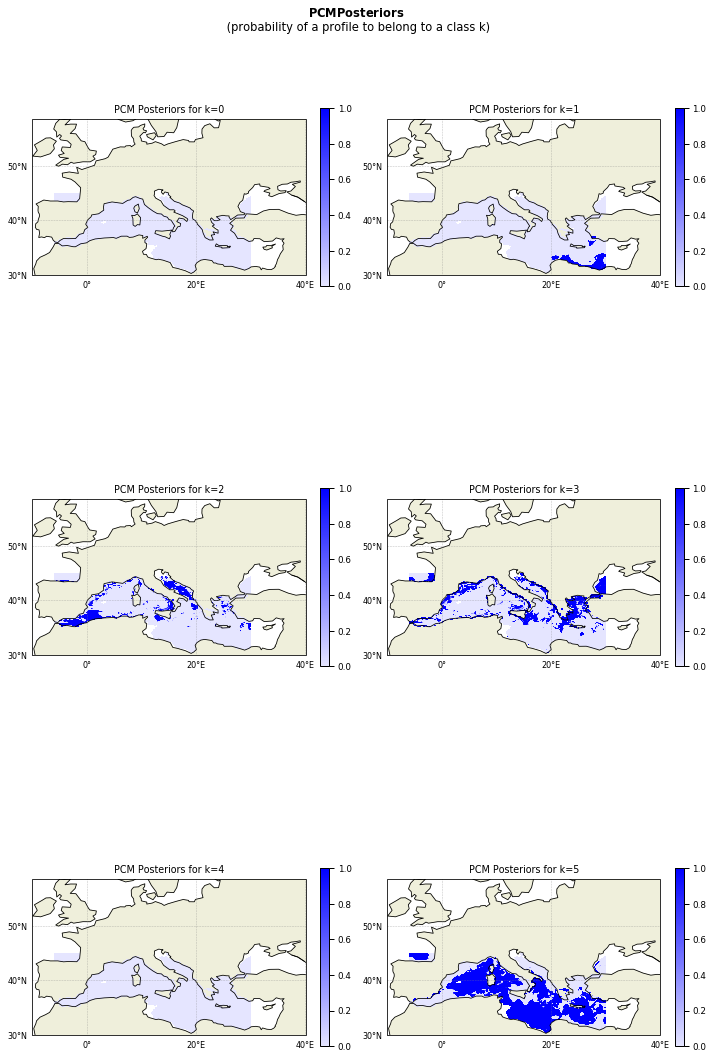

In [20]:
# Input should have only one time step
Ps.plot_posteriors(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'latitude', 'longitude':'longitude'})
Ps.save_BlueCloud('figures/posteriors_EX.png')

#### 4. Temporal representation 

Simple histogram

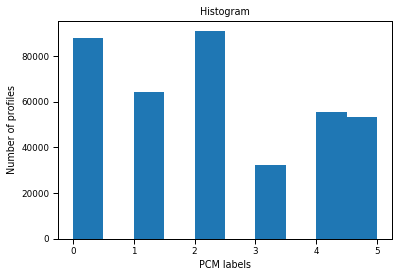

In [21]:
fig, axes = plt.subplots()
ds['PCM_LABELS'].plot.hist()
# y axis is number of profiles
axes.set_ylabel('Number of profiles')
plt.show()

Bar plot by __month__

Figure saved in figures/temporal_distr_months_EX.png


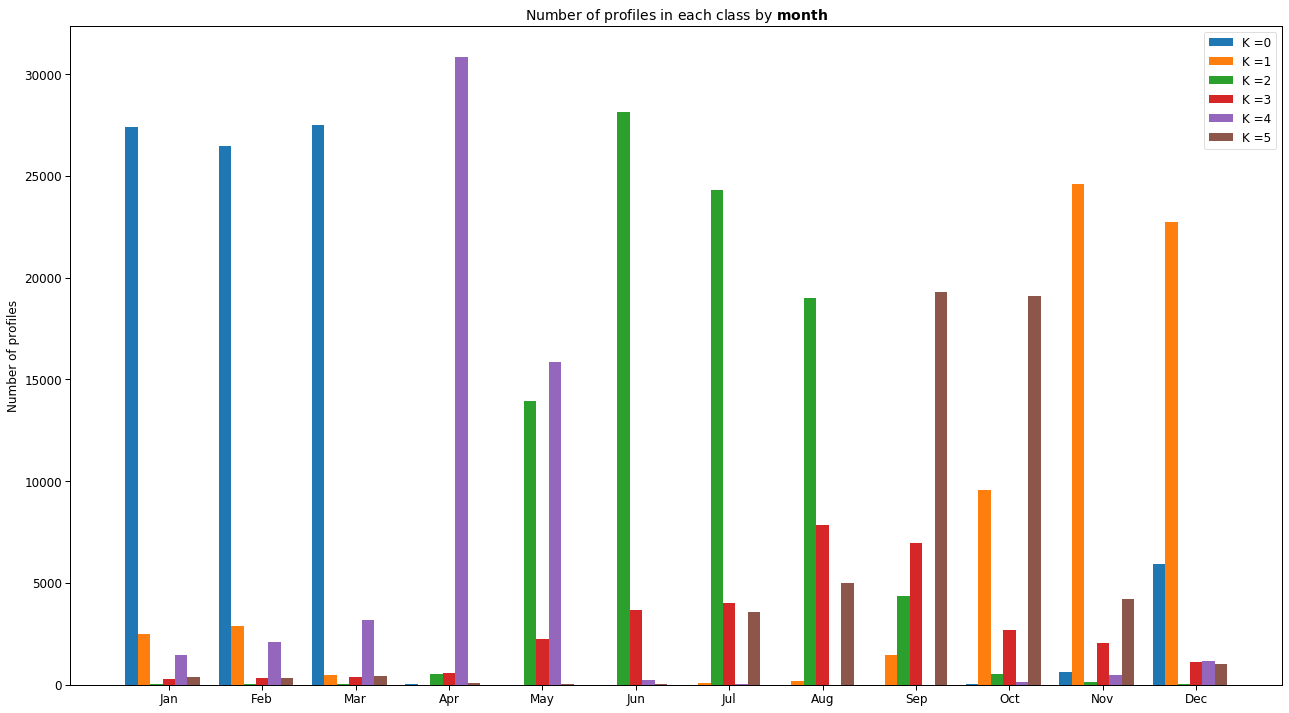

In [22]:
P.temporal_distribution(time_variable = 'time', time_bins = 'month', pond = 'abs')
P.save_BlueCloud('figures/temporal_distr_months_EX.png')

Bar plot by __month__ (__relative__ number of profiles per month)

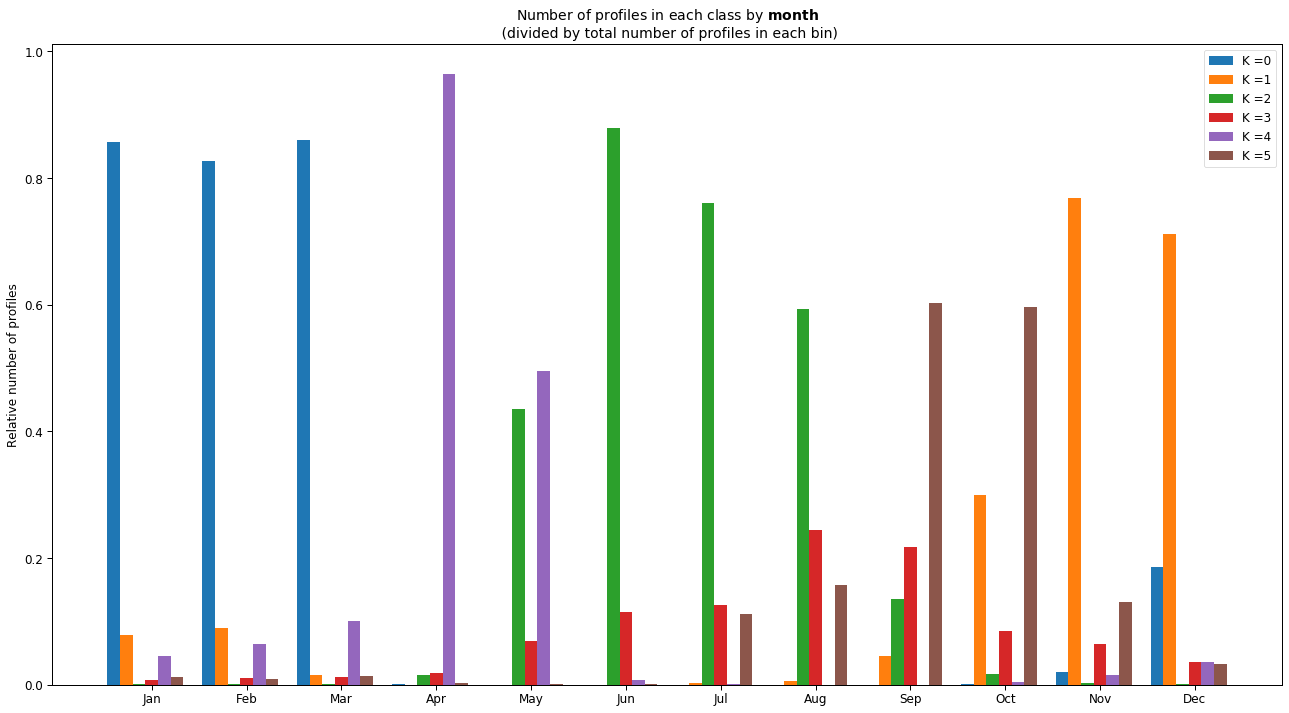

In [23]:
P.temporal_distribution(time_variable = 'time', time_bins = 'month', pond = 'rel')

Bar plot by __season__

Figure saved in figures/temporal_distr_season_EX.png


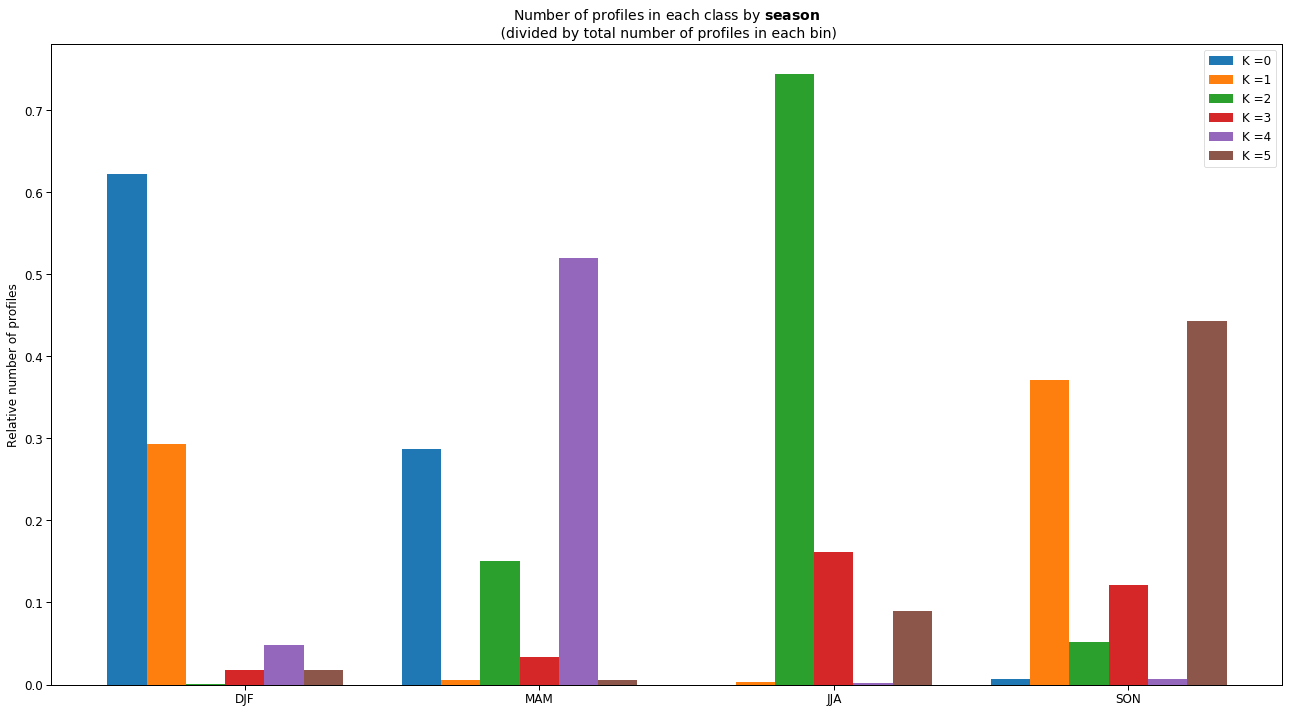

In [24]:
P.temporal_distribution(time_variable = 'time', time_bins = 'season', pond = 'rel')
P.save_BlueCloud('figures/temporal_distr_season_EX.png')